### This script will plot composite average PDSI, Precipitation, and Temperature anomaly maps based on early Grape Harvest Dates.

In [14]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.basemap import Basemap, cm

# Embeds plots inside the notebook (use in iPython Notebook)
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

# Resampling function
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

In [2]:
# User defined variables
# Years to sample from
#yr_samp = np.arange(1600,1951); yr_txt = '1600-1950';
#yr_samp = np.arange(1951,2008); yr_txt = '1951-2007';
#yr_samp = np.arange(1951,1981); yr_txt = '1951-1980';
#yr_samp = np.arange(1981,2008); yr_txt = '1981-2007';

yr_samp = np.arange(1600,1981); yr_txt = '1600-1980';
#yr_samp = np.arange(1981,2008); yr_txt = '1981-2007';
#yr_samp = np.arange(1901,1951); yr_txt = '1901-1950';


#yr_samp = np.arange(1901,1951); yr_txt = '1901-1950';
#yr_samp = np.arange(1901,1981); yr_txt = '1901-1980';


# Rectangle Boundaries
lonmin=-2; lonmax=8; latmin=43; latmax=51

# baseline period for anomaly calculation. Should be same as base period in setp01_proc_ghd.py
base_period = np.arange(1600,1901)   

# User defined variables
# Set threshold GHD anomaly for compositing
harvest_thresh = -7.8;  # about 1 standard deviation for GHDmean or GHD core
#harvest_thresh = -3.9;  # about 1/2 standard deviation for GHDmean or GHD core

# GHD Data to choose
#ghd_name = 'GHDmean'
ghd_name = 'GHDcore'
#ghd_name = 'Bur'

print(yr_samp)

[1600 1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614
 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629
 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644
 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659
 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674
 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689
 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702 1703 1704
 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717 1718 1719
 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734
 1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749
 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764
 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779
 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794
 1795 1796 1

In [3]:
# Load and properly format wine data
infile= './data/ghd_anom_doy_v02.csv'   # Name of the original data file

df=pd.read_csv(infile)

# Pull out year and mean as float64
yr = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

# Calculate standard deviation over base period
loc=np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]
std_ghd = np.nanstd(ghd_mean[loc])

#%%############################################################################
# Load OWDA Data
#ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix_500.nc')
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix1_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_prec=ncfile_pauling.variables['lat'][:];
lon_prec=ncfile_pauling.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); # yr_luter_all = np.transpose(np.tile(yr_cru,(12,1))); yr_all = np.reshape(yr_all,(1344,1))

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

ncfile_pauling.close

<function Dataset.close>

In [4]:
#%%############################################################################
# Anomalize temperature/precipitation data and recenter PDSI to same baseline as GHD anomalies

# Find PDSI years for this period and calculate mean
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period)) & (yr_pdsi<=np.max(base_period))); i_yr_pdsi=i_yr_pdsi[0];
# Calculate Mean and recenter PDSI
base_mean_pdsi = np.mean(pdsi[i_yr_pdsi,:,:],axis=0)
pdsi_recenter=pdsi-base_mean_pdsi

# Calculate Mean and Anomalize Temperature
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period))); i_yr_temp=i_yr_temp[0];
tmp_DJF_mean = np.mean(tmp_DJF[i_yr_temp,:,:],axis=0)
tmp_MAM_mean = np.mean(tmp_MAM[i_yr_temp,:,:],axis=0)
tmp_JJA_mean = np.mean(tmp_JJA[i_yr_temp,:,:],axis=0)
tmp_SON_mean = np.mean(tmp_SON[i_yr_temp,:,:],axis=0)

tmp_DJF_anom = tmp_DJF-tmp_DJF_mean
tmp_MAM_anom = tmp_MAM-tmp_MAM_mean
tmp_JJA_anom = tmp_JJA-tmp_JJA_mean
tmp_SON_anom = tmp_SON-tmp_SON_mean

# Calculate Mean and Anomalize precipitation
i_yr_prec = np.where( (yr_paul>=np.min(base_period)) & (yr_paul<=np.max(base_period))); i_yr_prec=i_yr_prec[0];
pre_DJF_mean = np.mean(pre_DJF[i_yr_prec,:,:],axis=0)
pre_MAM_mean = np.mean(pre_MAM[i_yr_prec,:,:],axis=0)
pre_JJA_mean = np.mean(pre_JJA[i_yr_prec,:,:],axis=0)
pre_SON_mean = np.mean(pre_SON[i_yr_prec,:,:],axis=0)

pre_DJF_anom = pre_DJF-pre_DJF_mean
pre_MAM_anom = pre_MAM-pre_MAM_mean
pre_JJA_anom = pre_JJA-pre_JJA_mean
pre_SON_anom = pre_SON-pre_SON_mean

In [5]:
#%%############################################################################
# Now, find all years that exceed the threshold I set up before
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Trim to eliminate years before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs = np.delete(early_yrs,remove_locs)

# Find Early Harvest Years that fall within this interval
subset_yrs = np.intersect1d(yr_samp,early_yrs)

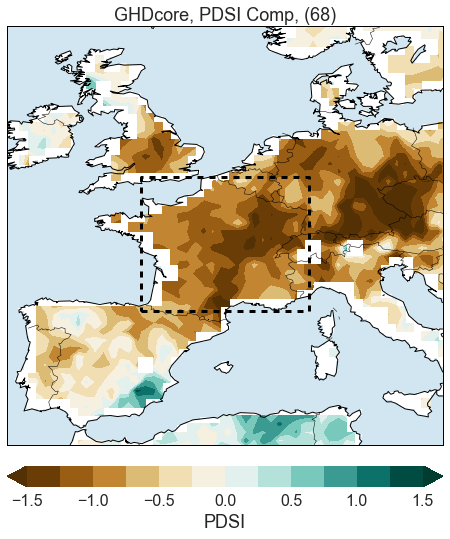

In [6]:
#%%############################################################################
# PDSI Maps
#print('yrsamp=',yr_samp)     
#print('early years=',early_yrs)
#print(subset_yrs)

# Find Early Harvest Years that fall within this interval
#subset_yrs = np.intersect1d(yr_samp,early_yrs)

# Find the locations in the PDSI Dataset
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs))==1)[0];

# Composite Average
pdsi_comp_all = np.mean(pdsi_recenter[pdsi_locs,:,:],axis=0)

lon_map = lon_pdsi; lat_map = lat_pdsi;

#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);
lonlim=np.array([-10,16]);
latlim=np.array([35,60]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', PDSI Comp, ('+np.str(np.size(pdsi_locs))+')'
fontdict = {'fontsize': 18}

# Map up composite
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=clevs*0.25
#cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=cm.GMT_drywet,extend="both")
cs = m.contourf(x,y,pdsi_comp_all,clevs,cmap=plt.cm.BrBG,extend="both")  # blue green to brown
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.ax.tick_params(labelsize=16)
cbar.set_label('PDSI',fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#out_txt = './figures/pdsi.comp.'+yr_txt+'.n'+np.str(np.size(pdsi_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.svg'
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = './figures/step05/pdsi.comp.'+yr_txt+'.n'+np.str(np.size(pdsi_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 


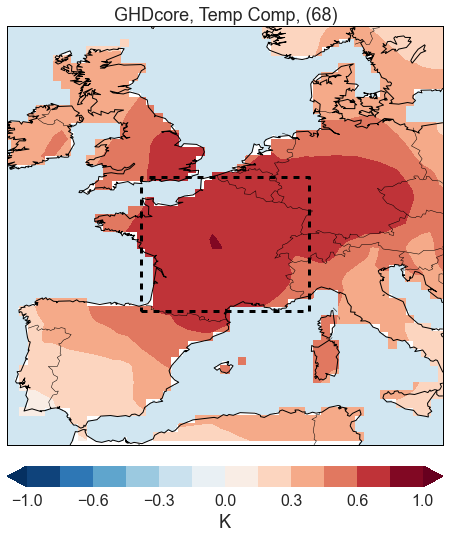

In [7]:
#%%############################################################################
# Temp Maps
# Choose Season of Temperature
tmp_seas = tmp_JJA_anom; seas_txt='JJA';
#tmp_seas = tmp_MAM_anom; seas_txt='MAM';
#tmp_seas = (tmp_MAM_anom+tmp_JJA_anom)/2; seas_txt='MAMJJA';

# Find the locations in the PDSI Dataset
temp_locs=np.where(np.int64(np.in1d(yr_luter,subset_yrs))==1)[0];

# Composite Average
tmp_comp_all = np.mean(tmp_seas[temp_locs,:,:],axis=0)

lon_map = lon_temp; lat_map = lat_temp;

# already set above
#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', Temp Comp, ('+np.str(np.size(temp_locs))+')'
fontdict = {'fontsize': 18}

# Map up correlation
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
#clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-1,-.85,-.6,-.45,-.3,-.15,0,.15,.3,.45,.6,.85,1]
clevs = [-1,-.85,-.6,-.45,-.3,-.15,0,.15,.3,.45,.6,.85,1]

#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=(clevs)
cs = m.contourf(x,y,tmp_comp_all,clevs,cmap=plt.cm.RdBu_r,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('K',fontsize=18)
cbar.ax.tick_params(labelsize=16)
# add title
plt.title(title_txt,fontdict)
plt.show()
#out_txt = './figures/temp.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.svg'
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = './figures/step05/temp.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 



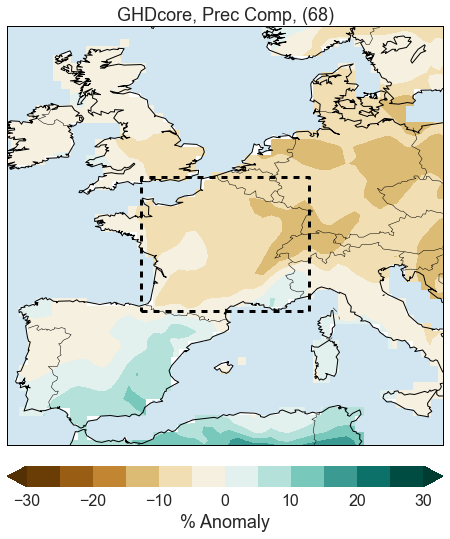

In [10]:
#%%############################################################################
# Precip Maps
prec_MAMJJA = (pre_JJA+pre_MAM); clim_MAMJJA = (pre_JJA_mean+pre_MAM_mean)

# Choose Season of Temperature
pre_seas = ((pre_JJA-pre_JJA_mean)/pre_JJA_mean)*100; seas_txt='JJA';
#pre_seas = ((pre_MAM-pre_MAM_mean)/pre_MAM_mean)*100; seas_txt='MAM';
#pre_seas = ((pre_DJF-pre_DJF_mean)/pre_DJF_mean)*100; seas_txt='DJF';
#pre_seas = ((prec_MAMJJA-clim_MAMJJA)/clim_MAMJJA)*100; seas_txt='MAMJJA';

# Find the locations in the PDSI Dataset
prec_locs=np.where(np.int64(np.in1d(yr_paul,subset_yrs))==1)[0];

# Composite Average
pre_comp_all = np.mean(pre_seas[prec_locs,:,:],axis=0)

lon_map = lon_prec; lat_map = lat_prec;

# already set above
#lonlim=np.array([np.min(lon_map),36]);
#latlim=np.array([30,np.max(lat_map)]);

# Regional Projections
proj_txt='cyl'      # Equidistant cyclindrical
#proj_txt='merc'     # Mercator projection
#proj_txt='mill'     # Miller cylindrical projection
#proj_txt='gall'     # Gall Stereographic Projection
#proj_txt='cea'       # Cylindrical equal area projection

lon_map, lat_map = np.meshgrid(lon_map, lat_map)

# MAP
# Title
#title_txt = ghd_name+', Spearman''s r, Temp ('+mons_ave_txt+')'
title_txt = ghd_name+', Prec Comp, ('+np.str(np.size(temp_locs))+')'
fontdict = {'fontsize': 18}

# Map up correlation
# Equidistant Cylindrical
fig = plt.figure(figsize=(16,8))
ax = fig.add_axes([0.1,0.1,0.8,0.8])
# equidistant cylindrical
m = Basemap(projection=proj_txt,resolution='l',\
            llcrnrlon=np.min(lonlim),llcrnrlat=np.min(latlim),\
            urcrnrlon=np.max(lonlim),urcrnrlat=np.max(latlim))
m.drawcoastlines()
m.drawstates()
m.drawcountries()
# draw parallels.
parallels = np.arange(0.,90,10.)
#m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
# draw meridians
meridians = np.arange(180.,360.,10.)
#m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)
#ny = data.shape[0]; nx = data.shape[1]
#lons, lats = m.makegrid(nx, ny) # get lat/lons of ny by nx evenly space grid.
x, y = m(lon_map, lat_map) # compute map proj coordinates.
# draw filled contours.
clevs = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
#clevs = [-.9,-.8,-.7,-.6,-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3,.4,.5,.6,.7,.8,.9]
clevs=np.asarray(clevs); clevs=(clevs*5)
cs = m.contourf(x,y,pre_comp_all,clevs,cmap=plt.cm.BrBG,extend="both")
m.drawmapboundary(fill_color='#99ffff')
m.drawlsmask(land_color='w', ocean_color=np.float64([209,230,241])/255)
# (6) PLOT RECTANGLE OVER THE REGION
plot_rectangle(m, lonmin, lonmax, latmin, latmax) 
# add colorbar.
cbar = m.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('% Anomaly',fontsize=18)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(fontsize=18)
# add title
plt.title(title_txt,fontdict)
plt.show()
#out_txt = './figures/temp.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.svg'
#fig.savefig(out_txt, format='svg', dpi=1200) # vector graphics for adobe illustrator 
out_txt = './figures/step05/prec.comp.'+seas_txt+'.'+yr_txt+'.n'+np.str(np.size(temp_locs))+'.'+np.str(np.abs(harvest_thresh))+'days.'+ghd_name+'.eps'
fig.savefig(out_txt, format='eps', dpi=300) # vector graphics for adobe illustrator 




In [24]:
np.size(yr_samp)

27